In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1710, 128, 757, 1)
X_test shape: (428, 128, 757, 1)
y_train shape: (1710, 2138)
y_test shape: (428, 2138)


CNN with CER(Max Pooling)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
14/14 [==============================] - 0s 15ms/step
 — val_cer: 0.9063
43/43 [==============================] - 9s 58ms/step - loss: 8.8898 - accuracy: 0.0000e+00 - val_loss: 7.6826 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.9496
43/43 [==============================] - 1s 34ms/step - loss: 7.6538 - accuracy: 0.0000e+00 - val_loss: 7.7100 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 9ms/step
 — val_cer: 0.9192
43/43 [==============================] - 2s 39ms/step - loss: 7.6397 - accuracy: 0.0000e+00 - val_loss: 7.7379 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 13ms/step
 — val_cer: 0.8057
43/43 [==============================] - 2s 49ms/step - loss: 7.6249 - accuracy: 0.0000e+00 - val_loss: 7.7659 - val_ac

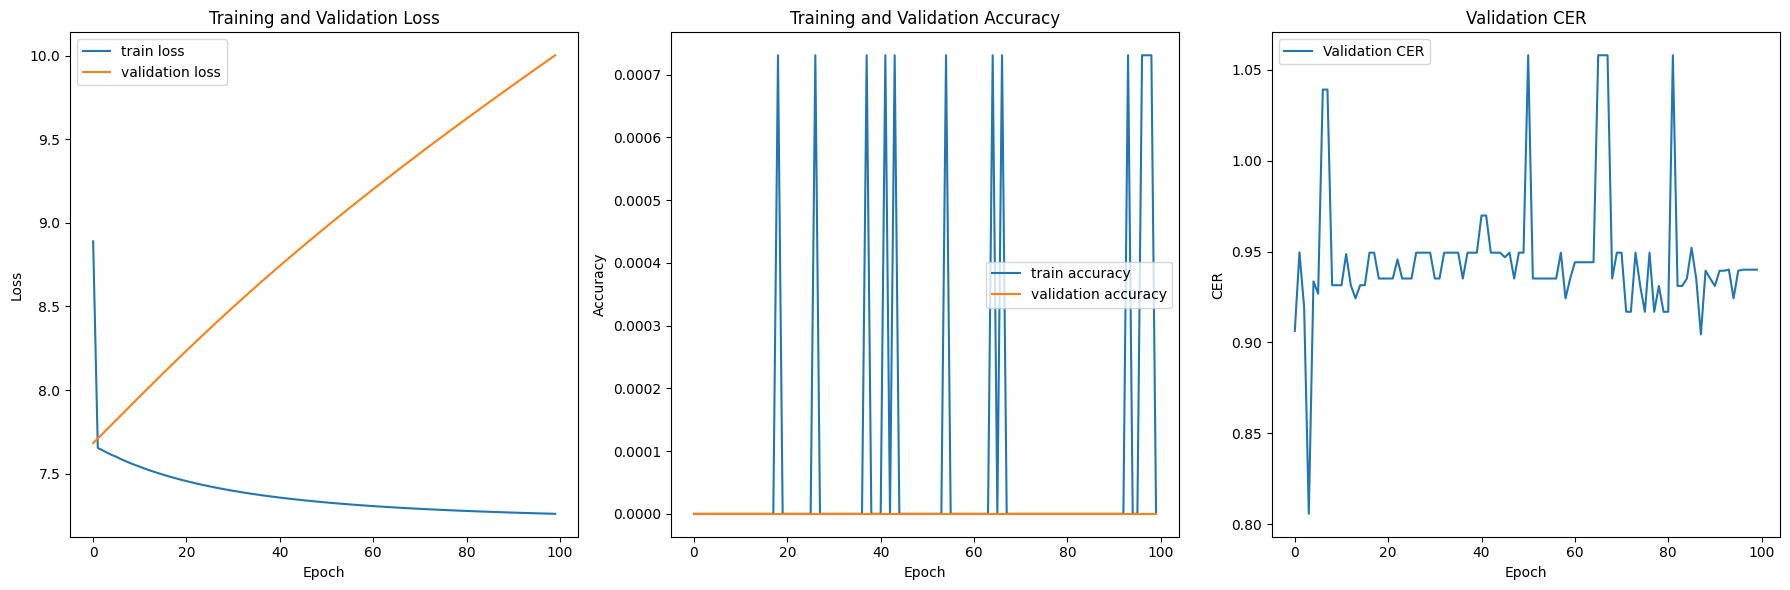

Average Train Accuracy: 8.771929889917374e-05
Average Validation Accuracy: 0.0
Average Validation CER: 0.9450214174454828
Correct Rate: 0.05497858255451715


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return ANS

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_test, y_test)

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')

model.save('/content/drive/My Drive/IntoAI/cnn_lstm_model.h5')


CNN with CER(Average Pooling)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
14/14 [==============================] - 0s 17ms/step
 — val_cer: 0.9153
43/43 [==============================] - 6s 59ms/step - loss: 8.9103 - accuracy: 0.0000e+00 - val_loss: 7.6831 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.9430
43/43 [==============================] - 1s 30ms/step - loss: 7.6555 - accuracy: 0.0000e+00 - val_loss: 7.7110 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.9537
43/43 [==============================] - 1s 30ms/step - loss: 7.6395 - accuracy: 0.0000e+00 - val_loss: 7.7391 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.9153
43/43 [==============================] - 1s 29ms/step - loss: 7.6255 - accuracy: 0.0000e+00 - val_loss: 7.7672 - val_acc

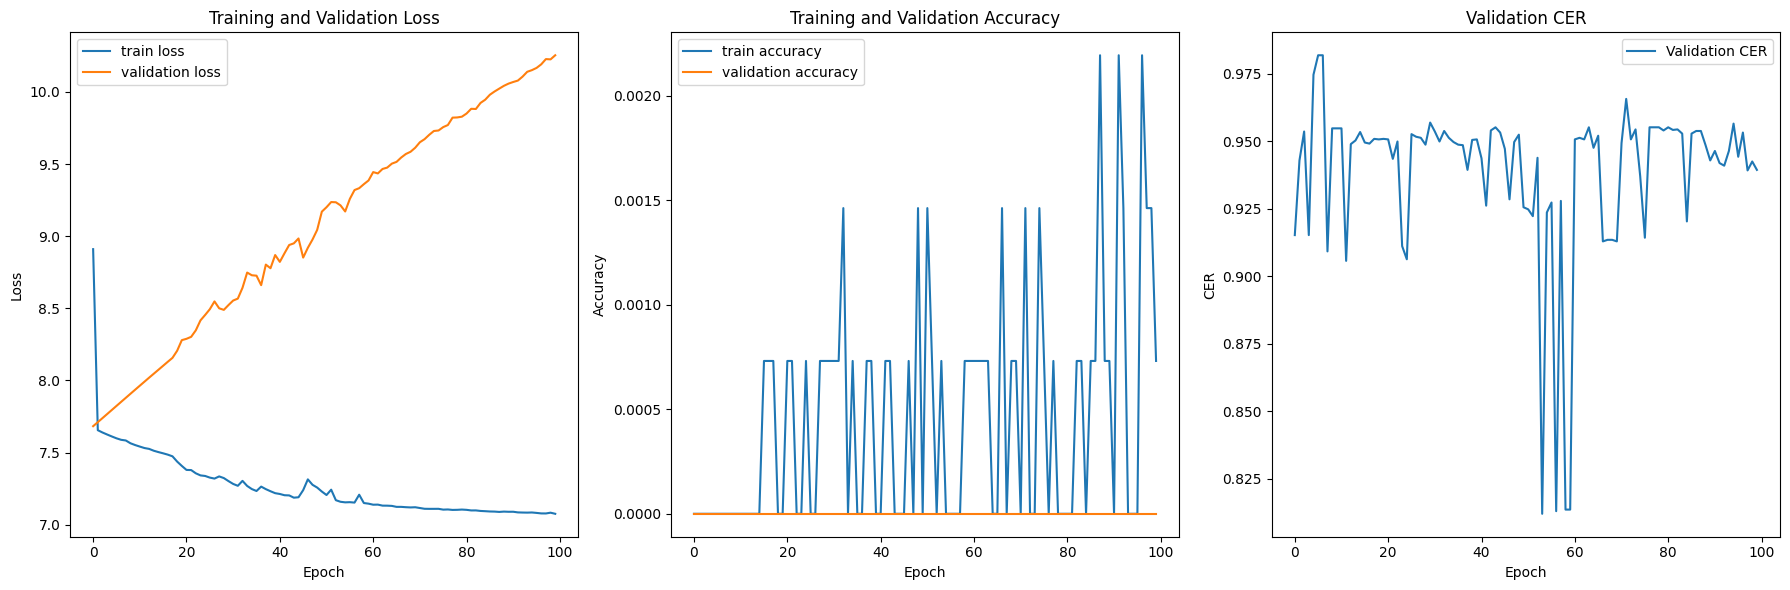

Average Train Accuracy: 0.0004605263192206621
Average Validation Accuracy: 0.0
Average Validation CER: 0.9392095015576324
Correct Rate: 0.06079049844236761


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return ANS

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_test, y_test)
cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')

model.save('/content/drive/My Drive/IntoAI/cnn_lstm_model.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
14/14 [==============================] - 0s 8ms/step
 — val_cer: 0.8213
43/43 [==============================] - 3s 46ms/step - loss: 9.2194 - accuracy: 0.0000e+00 - val_loss: 7.6831 - val_accuracy: 0.0000e+00
Epoch 2/20
14/14 [==============================] - 0s 10ms/step
 — val_cer: 0.8834
43/43 [==============================] - 2s 41ms/step - loss: 7.6538 - accuracy: 0.0000e+00 - val_loss: 7.7113 - val_accuracy: 0.0000e+00
Epoch 3/20
14/14 [==============================] - 0s 14ms/step
 — val_cer: 0.9007
43/43 [==============================] - 3s 71ms/step - loss: 7.6391 - accuracy: 0.0000e+00 - val_loss: 7.7396 - val_accuracy: 0.0000e+00
Epoch 4/20
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.8213
43/43 [==============================] - 2s 38ms/step - loss: 7.6249 - accuracy: 7.3099e-04 - val_loss: 7.7680 - val_accura

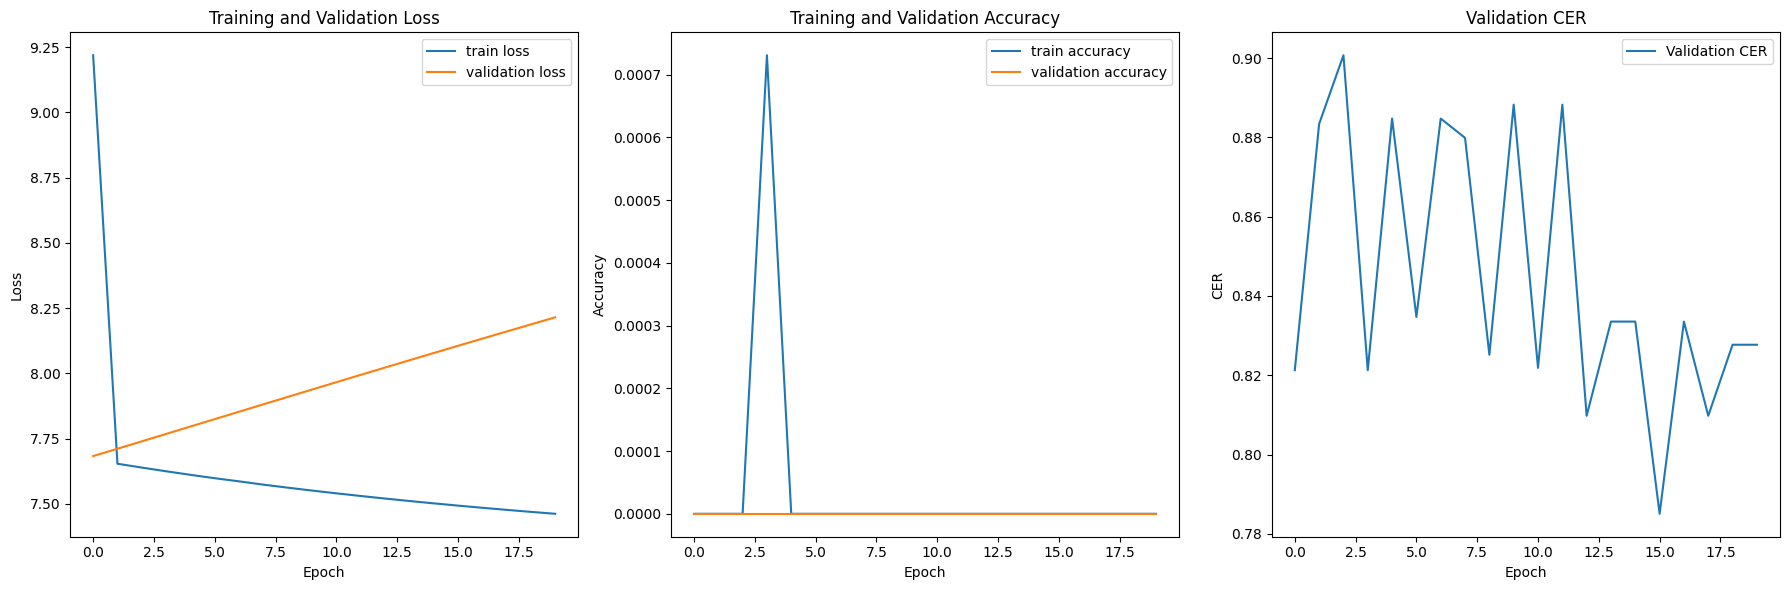

Average Train Accuracy: 3.654970787465572e-05
Average Validation Accuracy: 0.0
Average Validation CER: 0.8447332554517132
Correct Rate: 0.15526674454828682


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return min(ANS, 1.0)

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_test, y_test)

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')

model.save('/content/drive/My Drive/IntoAI/cnn_lstm_model.h5')


CNN+LSTM with CER (Max Pooling)

Shape after TimeDistributed layers: (None, 128, 24224)
Shape after first LSTM layer: (None, 128, 128)
Shape after second LSTM layer: (None, 128)
Shape after Dense layer: (None, 128)
Final model shape: (None, 2138)
Epoch 1/20
11/11 [==============================] - 1s 46ms/step
 — val_cer: 0.9096
43/43 [==============================] - 16s 258ms/step - loss: 7.6876 - accuracy: 0.0000e+00 - val_loss: 7.6850 - val_accuracy: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 1s 53ms/step
 — val_cer: 0.9335
43/43 [==============================] - 9s 200ms/step - loss: 7.6513 - accuracy: 0.0000e+00 - val_loss: 7.8928 - val_accuracy: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 1s 49ms/step
 — val_cer: 0.9288
43/43 [==============================] - 9s 201ms/step - loss: 7.5665 - accuracy: 7.3099e-04 - val_loss: 8.3154 - val_accuracy: 0.0000e+00
Epoch 4/20
11/11 [==============================] - 1s 50ms/step
 — val_cer: 0.9335
43/43 [=========================

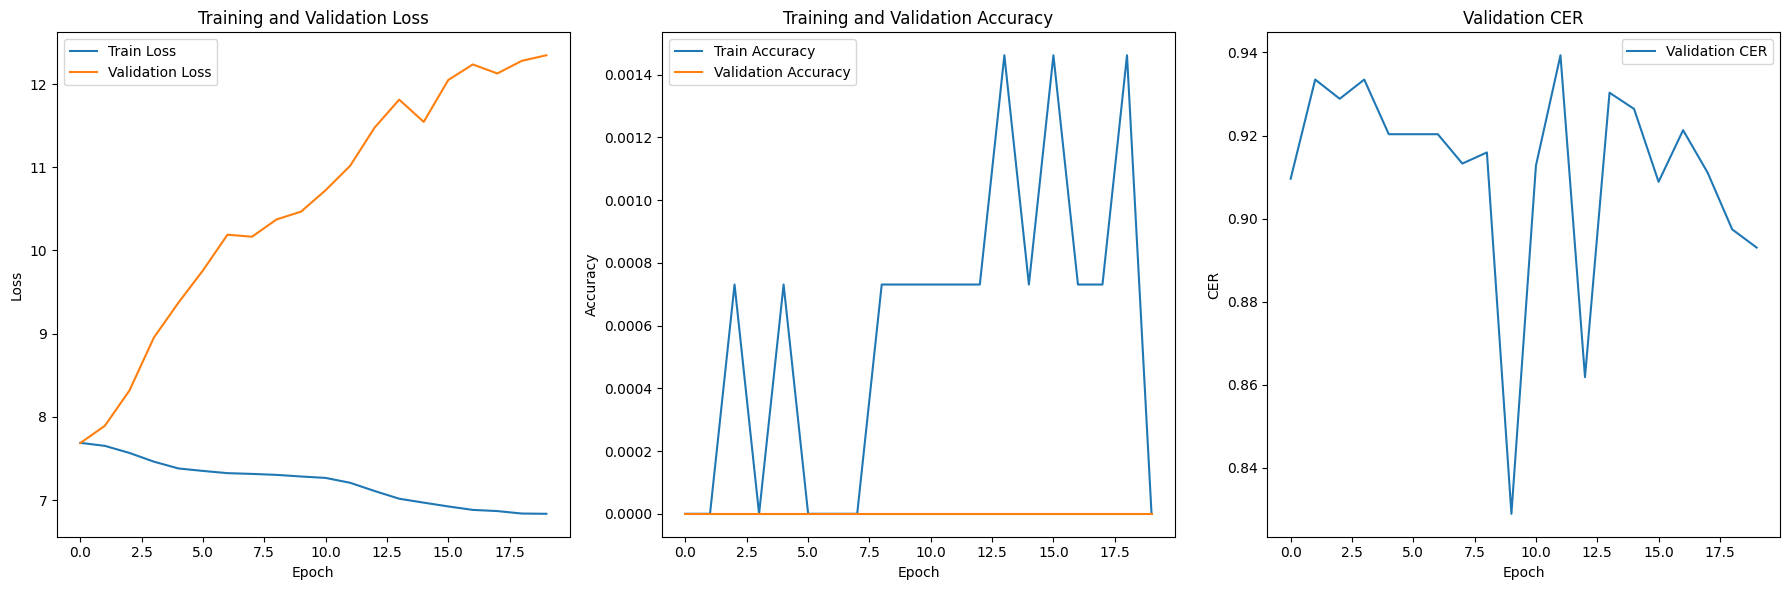

Average Train Accuracy: 0.0005847953259944915
Average Validation Accuracy: 0.0
Average Validation CER: 0.9113425925925925
Correct Rate: 0.08865740740740746


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, AveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

model = Sequential()

model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(1, 1), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Flatten()))

print("Shape after TimeDistributed layers:", model.output_shape)
model.add(LSTM(128, return_sequences=True))
print("Shape after first LSTM layer:", model.output_shape)
model.add(Dropout(0.2))
model.add(LSTM(128))
print("Shape after second LSTM layer:", model.output_shape)
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
print("Shape after Dense layer:", model.output_shape)

model.add(Dense(y_train.shape[1], activation='softmax'))
print("Final model shape:", model.output_shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return ANS

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_train[int(len(X_train)*0.8):], y_train[int(len(y_train)*0.8):])

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')


CNN avoid CER>1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
14/14 [==============================] - 0s 10ms/step
 — val_cer: 0.8294
43/43 [==============================] - 4s 62ms/step - loss: 9.6403 - accuracy: 0.0000e+00 - val_loss: 7.6832 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 10ms/step
 — val_cer: 0.8904
43/43 [==============================] - 2s 56ms/step - loss: 7.6536 - accuracy: 0.0000e+00 - val_loss: 7.7113 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.7800
43/43 [==============================] - 2s 39ms/step - loss: 7.6388 - accuracy: 0.0000e+00 - val_loss: 7.7394 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 7ms/step
 — val_cer: 0.9356
43/43 [==============================] - 2s 37ms/step - loss: 7.6246 - accuracy: 0.0000e+00 - val_loss: 7.7676 - val_ac

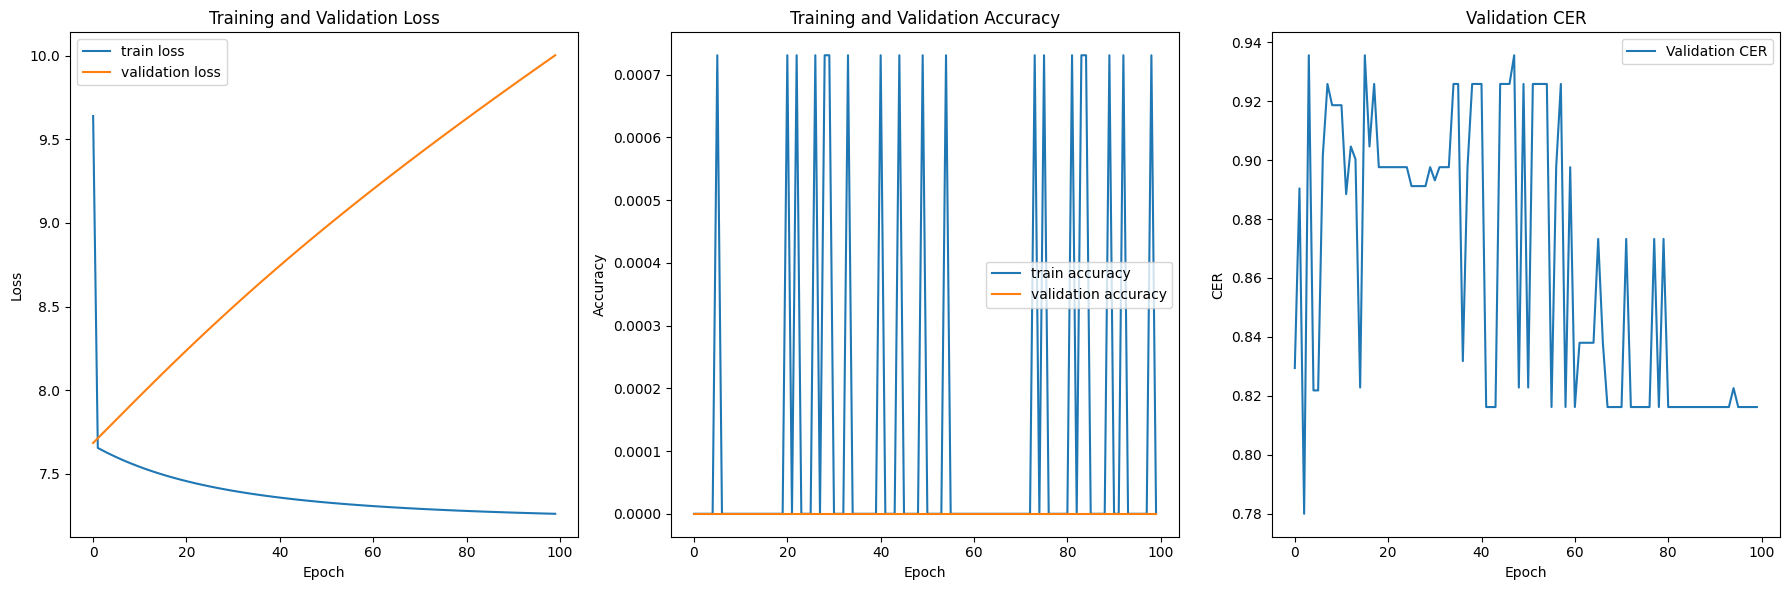

Average Train Accuracy: 0.00013888888992369175
Average Validation Accuracy: 0.0
Average Validation CER: 0.8641530373831775
Correct Rate: 0.1358469626168225


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return min(ANS, 1.0)

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_test, y_test)

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1 - np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')

model.save('/content/drive/My Drive/IntoAI/cnn_lstm_model.h5')


CNN+LSTM avoid CER > 1

Shape after TimeDistributed layers: (None, 128, 24224)
Shape after first LSTM layer: (None, 128, 128)
Shape after second LSTM layer: (None, 128)
Shape after Dense layer: (None, 128)
Final model shape: (None, 2138)
Epoch 1/100
11/11 [==============================] - 1s 47ms/step
 — val_cer: 0.8606
43/43 [==============================] - 14s 250ms/step - loss: 7.6916 - accuracy: 0.0000e+00 - val_loss: 7.6884 - val_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 1s 52ms/step
 — val_cer: 0.8112
43/43 [==============================] - 9s 208ms/step - loss: 7.6453 - accuracy: 0.0000e+00 - val_loss: 8.0290 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 1s 51ms/step
 — val_cer: 0.8187
43/43 [==============================] - 9s 202ms/step - loss: 7.5550 - accuracy: 7.3099e-04 - val_loss: 8.3031 - val_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 1s 50ms/step
 — val_cer: 0.8170
43/43 [=====================

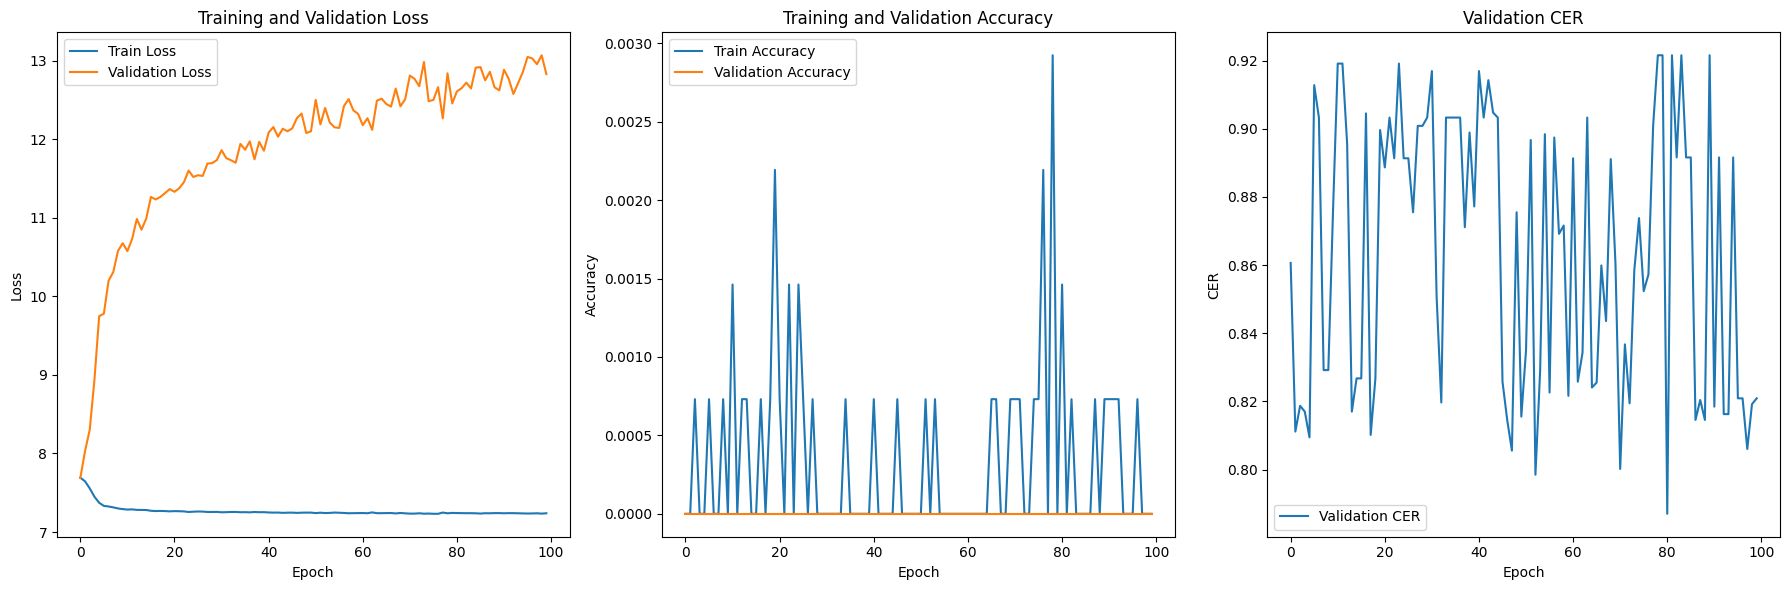

Average Train Accuracy: 0.00034356725402176383
Average Validation Accuracy: 0.0
Average Validation CER: 0.863445419103314
Correct Rate: 0.13655458089668604


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, AveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

model = Sequential()

model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(1, 1), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Flatten()))

print("Shape after TimeDistributed layers:", model.output_shape)

model.add(LSTM(128, return_sequences=True))
print("Shape after first LSTM layer:", model.output_shape)
model.add(Dropout(0.2))
model.add(LSTM(128))
print("Shape after second LSTM layer:", model.output_shape)
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
print("Shape after Dense layer:", model.output_shape)

model.add(Dense(y_train.shape[1], activation='softmax'))
print("Final model shape:", model.output_shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return min(ANS, 1.0)

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_train[int(len(X_train)*0.8):], y_train[int(len(y_train)*0.8):])

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')


CNN+LSTM with CER (AveragePooling)

Shape after TimeDistributed layers: (None, 128, 24224)
Shape after first LSTM layer: (None, 128, 128)
Shape after second LSTM layer: (None, 128)
Shape after Dense layer: (None, 128)
Final model shape: (None, 2138)
Epoch 1/100
11/11 [==============================] - 1s 46ms/step
 — val_cer: 0.8043
43/43 [==============================] - 22s 275ms/step - loss: 7.6918 - accuracy: 0.0000e+00 - val_loss: 7.6858 - val_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 1s 50ms/step
 — val_cer: 0.9008
43/43 [==============================] - 9s 199ms/step - loss: 7.6537 - accuracy: 0.0000e+00 - val_loss: 7.8231 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 1s 50ms/step
 — val_cer: 0.9130
43/43 [==============================] - 9s 206ms/step - loss: 7.5844 - accuracy: 0.0000e+00 - val_loss: 8.2033 - val_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 1s 51ms/step
 — val_cer: 0.8229
43/43 [=====================

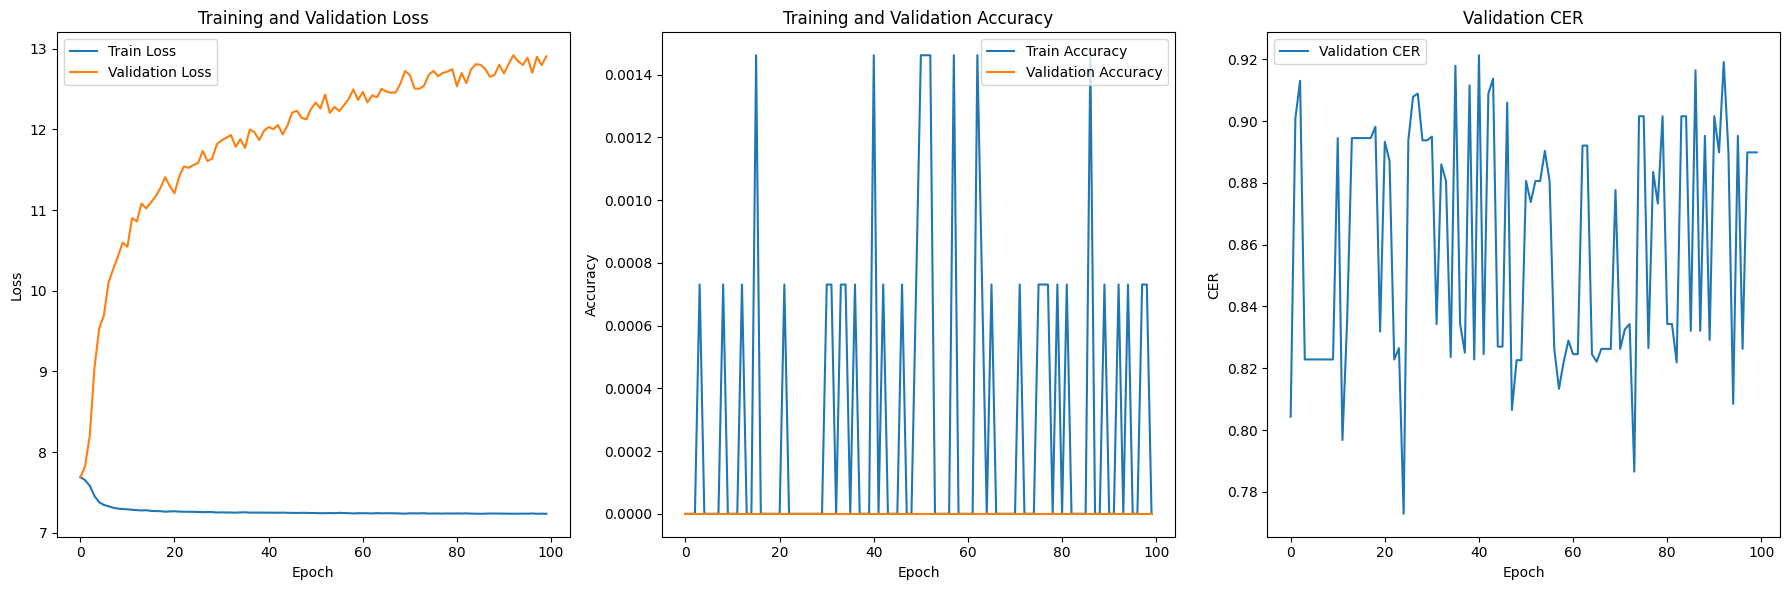

Average Train Accuracy: 0.00029970760457217696
Average Validation Accuracy: 0.0
Average Validation CER: 0.8599951267056529
Correct Rate: 0.14000487329434708


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, AveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

X_train = np.load('/content/drive/My Drive/IntoAI/X_train_origin.npy')
X_test = np.load('/content/drive/My Drive/IntoAI/X_test_origin.npy')
y_train = np.load('/content/drive/My Drive/IntoAI/y_train_origin.npy')
y_test = np.load('/content/drive/My Drive/IntoAI/y_test_origin.npy')

model = Sequential()

model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(1, 1), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)))
model.add(TimeDistributed(AveragePooling2D(pool_size=(1, 1))))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Flatten()))

print("Shape after TimeDistributed layers:", model.output_shape)

model.add(LSTM(128, return_sequences=True))
print("Shape after first LSTM layer:", model.output_shape)
model.add(Dropout(0.2))
model.add(LSTM(128))
print("Shape after second LSTM layer:", model.output_shape)
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
print("Shape after Dense layer:", model.output_shape)

model.add(Dense(y_train.shape[1], activation='softmax'))
print("Final model shape:", model.output_shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def cer(ref, hyp):
    ref = str(ref)
    hyp = str(hyp)
    n = len(ref)
    m = len(hyp)
    d = np.zeros((n+1)*(m+1), dtype=np.uint8).reshape((n+1, m+1))

    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    ANS = 0.0
    if float(n) != 0:
        ANS = d[n][m] / float(n)
    else:
        ANS = d[n][m]
    return min(ANS, 1.0)

class CERCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.cer_values = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        cer_scores = []
        for i in range(len(val_targ)):
            cer_scores.append(cer(val_targ[i], val_predict[i]))

        avg_cer = np.mean(cer_scores)
        self.cer_values.append(avg_cer)
        print(f' — val_cer: {avg_cer:.4f}')

val_data = (X_train[int(len(X_train)*0.8):], y_train[int(len(y_train)*0.8):])

cer_callback = CERCallback(val_data)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[cer_callback])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(cer_callback.cer_values, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER')

plt.tight_layout()
plt.show()

train_accuracy_avg = np.mean(history.history['accuracy'])
val_accuracy_avg = np.mean(history.history['val_accuracy'])
correct = 1-np.mean(cer_callback.cer_values)
print(f'Average Train Accuracy: {train_accuracy_avg}')
print(f'Average Validation Accuracy: {val_accuracy_avg}')
print(f'Average Validation CER: {np.mean(cer_callback.cer_values)}')
print(f'Correct Rate: {correct}')
